In [70]:
import Pkg
Pkg.activate(@__DIR__)

  Activating environment at `~/Desktop/sparse_trajopt/Project.toml`


In [71]:
# add my dense/sparse fmincon package from 
# https://github.com/kevin-tracy/lazy_nlp_qd.jl
Pkg.add(url="https://github.com/kevin-tracy/lazy_nlp_qd.jl.git")

    Updating git-repo `https://github.com/kevin-tracy/lazy_nlp_qd.jl.git`
   Resolving package versions...
  No Changes to `~/Desktop/sparse_trajopt/Project.toml`
  No Changes to `~/Desktop/sparse_trajopt/Manifest.toml`
Precompiling project...
  ✓ PrecompileTools
  ✓ JLLWrappers
  ✓ ASL_jll
  ✓ METIS_jll
  ✓ OpenSpecFun_jll
  ✓ OpenBLAS32_jll
  ✓ Bzip2_jll
  ✓ CodecBzip2
  ✓ MUMPS_seq_jll
  ✓ Ipopt_jll
  ✓ SpecialFunctions
  ✓ DiffRules
  ✓ StaticArrays
  ✓ FiniteDiff
  ✓ Parsers
  ✓ ForwardDiff
  ✓ JSON
  ✓ BenchmarkTools
  ✓ MathOptInterface
  ✓ Ipopt
  ✓ lazy_nlp_qd
  21 dependencies successfully precompiled in 61 seconds (28 already precompiled)
  21 dependencies precompiled but different versions are currently loaded. Restart julia to access the new versions


In [72]:
Pkg.status()

      Status `~/Desktop/sparse_trajopt/Project.toml`
  [f6369f11] ForwardDiff v0.10.36
  [ecc97b5a] lazy_nlp_qd v0.1.0 `https://github.com/kevin-tracy/lazy_nlp_qd.jl.git#main`


In [73]:
using LinearAlgebra
using SparseArrays
using Test
import ForwardDiff as FD 
using Plots

## Create a Random QP

In [74]:
function gen_sparse_qp(nx, ny, nz, fill_ratio)
    Q = sprandn(nx, nx, fill_ratio)
    Q = Q'*Q + I 

    A = sprandn(ny, nx, fill_ratio)
    A[1:ny,1:ny] += I 

    G = sprandn(nz, nx, fill_ratio)

    x = randn(nx)
    y = randn(ny)

    s = zeros(nz)
    z = zeros(nz)

    for i = 1:nz
        if randn() < 0 
            s[i] = abs(randn())
        else
            z[i] = abs(randn())
        end
    end

    b = A * x 
    h = G * x + s 

    q = -(Q*x + A'*y + G'*z)

    # assert that the problem we created satsifies KKT
    @assert norm(Q*x + q + A'*y + G'*z) < 1e-10 
    @assert abs(s'*z) < 1e-10 
    @assert minimum(s) >= 0 
    @assert minimum(z) >= 0 
    @assert norm(A*x - b) < 1e-10 
    @assert norm(G*x + s - h) < 1e-10 
    println("created QP successfully")

    Q, q, A, b, G, h, x
end

gen_sparse_qp (generic function with 1 method)

## Dense fmincon

For dense problems, we use the following NLP format:

$$
\begin{align*}
\underset{x}{\text{minimize}} & \quad f(x) \\
\text{subject to} & \quad  x_L \leq x \leq x_U, \\
                  & \quad  c_{eq}(x) = 0, \\ 
                  & \quad  c_L \leq c_{ineq}(x) \leq c_U,
\end{align*}
$$

Now let's solve the following QP
$$
\begin{align*}
\underset{x}{\text{minimize}} & \quad \frac{1}{2}x^TQx + q^Tx \\
\text{subject to} & \quad Ax = b, \\
                  & \quad Gx \leq h,
\end{align*}
$$

In [75]:
let 


    nx = 30 
    ny = 10 
    nz = 20 
    Q, q, A, b, G, h, x_solution = gen_sparse_qp(nx, ny, nz, 0.3)
    
    # convert everything to dense 
    Q = Matrix(Q)
    A = Matrix(A)
    G = Matrix(G)



    function my_cost(params, x)
        return .5*x'*params.Q*x + params.q'x 
    end

    function my_equality_constraint(params, x)
        return params.A*x - params.b 
    end

    function my_inequality_constraint(params, x)
        return params.G*x - params.h
    end

    
    # primal variable bounds 
    x_l = -Inf * ones(nx)
    x_u =  Inf * ones(nx)

    # constraint bounds 
    c_l = -Inf * ones(nz)
    c_u = zeros(nz)

    
    # things I need for my functions 
    params = (
        Q = Q, 
        q = q, 
        A = A, 
        b = b, 
        G = G, 
        h = h
    )

    # initial guess
    x0 = .1*randn(nx)


    diff_type = :auto # or :finite 

    x = lazy_nlp_qd.fmincon_dense(my_cost::Function,
                                  my_equality_constraint::Function,
                                  my_inequality_constraint::Function,
                                  x_l::Vector,
                                  x_u::Vector,
                                  c_l::Vector,
                                  c_u::Vector,
                                  x0::Vector,
                                  params::NamedTuple,
                                  diff_type::Symbol;
                                  tol = 1e-4,
                                  c_tol = 1e-4,
                                  max_iters = 1_000,
                                  verbose = true)


    @test norm(x - x_solution, Inf) < 1e-3


end

created QP successfully
---------checking dimensions of everything----------
---------all dimensions good------------------------
---------diff type set to :auto (ForwardDiff.jl)----
---------testing objective gradient-----------------
---------testing constraint Jacobian----------------
---------successfully compiled both derivatives-----
---------IPOPT beginning solve----------------------
This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      300
Number of nonzeros in inequality constraint Jacobian.:      600
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       30
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       10
Total number of inequ

Test Passed

## Sparse fmincon

For sparse problems, we use the following NLP format:

$$
\begin{align*}
\underset{x}{\text{minimize}} & \quad f(x) \\
\text{subject to} & \quad  x_L \leq x \leq x_U, \\
                  & \quad  c_L \leq c(x) \leq c_U,
\end{align*}
$$

Now let's solve the following QP
$$
\begin{align*}
\underset{x}{\text{minimize}} & \quad \frac{1}{2}x^TQx + q^Tx \\
\text{subject to} & \quad Ax = b, \\
                  & \quad Gx \leq h,
\end{align*}
$$

by first converting it into our accepted format:

$$
\begin{align*}
\underset{x}{\text{minimize}} & \quad \frac{1}{2}x^TQx + q^Tx \\
\text{subject to} & \quad 0 \leq Ax - b \leq 0 , \\
                  & \quad -\infty \leq Gx - h \leq 0,
\end{align*}
$$

In [76]:
import lazy_nlp_qd

let 
    nx = 30 
    ny = 10 
    nz = 20
    # check test/fmincon_sparse_test.jl for this function
    Q, q, A, b, G, h, x_solution = gen_sparse_qp(nx, ny, nz, 0.3)

    function my_cost(params, x)
        return .5*x'*params.Q*x + params.q'x 
    end

    function my_cost_gradient!(params, grad, x)
        # edit grad in-place 
        grad .= params.Q*x + params.q 
        return nothing
    end

    function my_constraint!(params, cval, x)
        # edit cval in place 
        cval .= [params.A; params.G] * x - [params.b; params.h]
        return nothing 
    end

    function my_constraint_jacobian!(params, conjac, x)
        conjac .= sparse([params.A; params.G])
        return nothing 
    end
    
    # primal variable bounds 
    x_l = -Inf * ones(nx)
    x_u =  Inf * ones(nx)

    # constraint bounds 
    c_l = [zeros(ny); -Inf * ones(nz)]
    c_u = [zeros(ny); zeros(nz)]

    # sparse jacobian matrix with correct sparsity pattern
    temp_con_jac = sparse([A;G])
    
    println("jacobian sparsity pattern: ")
    display(temp_con_jac)
    
    # things I need for my functions 
    params = (
        Q = Q, 
        q = q, 
        A = A, 
        b = b, 
        G = G, 
        h = h
    )

    # initial guess
    x0 = .1*randn(nx)

    """ we are solving the following problem:
    
        minimize_x        cost(x)
        subject to        c_L <= constraint(x) <= c_U
                          x_L <= x <= x_U
    """
 
    x = lazy_nlp_qd.sparse_fmincon(my_cost::Function,
                                   my_cost_gradient!::Function,
                                   my_constraint!::Function,
                                   my_constraint_jacobian!::Function,
                                   temp_con_jac, # example of jac sparsity pattern
                                   x_l::Vector,
                                   x_u::Vector,
                                   c_l::Vector,
                                   c_u::Vector,
                                   x0::Vector,
                                   params::NamedTuple;
                                   tol = 1e-4,
                                   c_tol = 1e-4,
                                   max_iters = 1_000,
                                   verbose = true)

    @test norm(x - x_solution, Inf) < 1e-3
end

created QP successfully
jacobian sparsity pattern: 


30×30 SparseMatrixCSC{Float64, Int64} with 290 stored entries:
⠱⢇⡑⢀⢠⠌⣐⣤⢑⢀⡨⠈⣅⠆⠈
⡑⢫⠑⢜⡱⠔⡐⣦⠩⠈⠂⢂⠐⠀⠢
⢂⢴⠼⠈⣱⢅⠃⢀⠶⢨⠂⠬⢃⡨⠐
⠲⡂⠡⠞⠻⠇⠉⢠⡨⠨⣀⠈⠂⠍⠓
⠈⣥⢠⠶⠥⣐⣩⠀⡨⠆⣈⠗⠅⠠⣆
⡈⠩⠉⢐⠈⠘⠔⠦⢧⠝⠔⢄⡚⠅⡀
⠋⠐⡌⠁⠈⢄⣬⠊⢤⠹⣂⠡⠈⣨⠂
⠈⠁⠒⠙⠓⠀⠈⠒⠐⠐⠘⠀⠐⠒⠚

---------checking dimensions of everything----------
---------checking bounds----------------------------
---------IPOPT beginning solve----------------------
This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:       93
Number of nonzeros in inequality constraint Jacobian.:      197
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       30
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       10
Total number of inequality constraints...............:       20
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       20



Test Passed

## Sparse Trajectory Optimization

In [77]:

function dynamics(params::NamedTuple, x::Vector, u)
    # cartpole ODE, parametrized by params. 

    # cartpole physical parameters 
    mc, mp, l = params.mc, params.mp, params.l

    g = 9.81
    
    q = x[1:2]
    qd = x[3:4]

    s = sin(q[2])
    c = cos(q[2])

    H = [mc+mp mp*l*c; mp*l*c mp*l^2]
    C = [0 -mp*qd[2]*l*s; 0 0]
    G = [0, mp*g*l*s]
    B = [1, 0]

    qdd = -H\(C*qd + G - B*u[1])
    xdot = [qd;qdd]
    return xdot 

end

# vanilla rk4 explicit integrator 
function rk4(params,x,u)
    dt = params.dt 
    k1 = dt * dynamics(params, x,        u)
    k2 = dt * dynamics(params, x + k1/2, u)
    k3 = dt * dynamics(params, x + k2/2, u)
    k4 = dt * dynamics(params, x + k3,   u)
    x + (1 / 6) * (k1 + 2 * k2 + 2 * k3 + k4)
end

function create_idx(nx,nu,N)
    # This function creates some useful indexing tools for Z 
    # x_i = Z[idx.x[i]]
    # u_i = Z[idx.u[i]]
    
    # our Z vector is [x0, u0, x1, u1, …, xN]
    nz = (N-1) * nu + N * nx # length of Z 
    x = [(i - 1) * (nx + nu) .+ (1 : nx) for i = 1:N]
    u = [(i - 1) * (nx + nu) .+ ((nx + 1):(nx + nu)) for i = 1:(N - 1)]
    
    # constraint indexing for the (N-1) dynamics constraints when stacked up
    c = [(i - 1) * (nx) .+ (1 : nx) for i = 1:(N - 1)]
    nc = (N - 1) * nx # (N-1)*nx 
    
    return (nx=nx,nu=nu,N=N,nz=nz,nc=nc,x= x,u = u,c = c)
end

# user-defined functions for trajectory optimization 


function cost(params, Z)
    # return trajectory cost 
    Xref, Uref = params.Xref, params.Uref 
    idx = params.idx  
    Q, R, Qf = params.Q, params.R, params.Qf 

    J = 0.0 
    for i = 1:idx.N-1 
        dx = Z[idx.x[i]] - Xref[i]
        du = Z[idx.u[i]] - Uref[i] 
        J += 0.5*dx'*Q*dx + 0.5*du'*R*du 
    end
    
    dx = Z[idx.x[idx.N]] - Xref[idx.N]
    J += 0.5*dx'*Qf*dx 
    return J 
end

function cost_gradient!(params, grad, Z)
    # calculate cost gradient and put it in grad 
    # i used forward diff but you can do it by hand 
    grad .= FD.gradient(_Z -> cost(params, _Z), Z)
    return nothing 
end

function constraint!(params, cval, Z)
    # calculate constraint value and put it in cval 
    idx = params.idx 
    # x0, xf = params.x0, params.xf 
    for i = 1:idx.N-1
        xi = Z[idx.x[i]]
        ui = Z[idx.u[i]]
        xi₊ = Z[idx.x[i+1]] 
        # you could put whatever integrator you wanted to here (implicit)
        cval[idx.c[i]] = xi₊ - rk4(params, xi,ui) 
    end

    # DEPRECATED: I moved these constraints to the primal variable bounds 
    # cval[idx.c[idx.N]] = Z[idx.x[1]] - x0
    # cval[idx.c[idx.N+1]] = Z[idx.x[idx.N]] - xf
    return nothing 
end

function constraint_jacobian!(params, conjac, Z)
    # calculate constraint jacobian and put it in conjac (a sparse matrix)
    idx = params.idx 

    for i = 1:idx.N-1
        xi = Z[idx.x[i]]
        ui = Z[idx.u[i]]
        xi₊ = Z[idx.x[i+1]] 
        
        # diff the following constraint wrt xi, ui, xi₊
        conjac[idx.c[i],idx.x[i]] .= -FD.jacobian(_x->rk4(params, _x,ui),xi)
        conjac[idx.c[i],idx.u[i]] .= -FD.jacobian(_u->rk4(params, xi,_u),ui)
        conjac[idx.c[i],idx.x[i+1]] .= I(idx.nx)
    end
    
    # DEPRECATED: I moved these constraints to the primal variable bounds 
    # diff the initial and terminal condition constraints wrt x1 and xN respectively
    # conjac[idx.c[idx.N],idx.x[1]] .= I(idx.nx)
    # conjac[idx.c[idx.N+1],idx.x[idx.N]] .= I(idx.nx)

    return nothing
end

constraint_jacobian! (generic function with 1 method)

sparsity pattern of conjac: 


160×204 SparseMatrixCSC{Float64, Int64} with 760 stored entries:
⠛⣷⣤⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠉⠾⣶⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠛⠷⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠉⠛⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⠿⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠉⠛⣷⣄⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢷⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⠻⢷⣄⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠙⢻⣦⣀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠹⢷⣤⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠙⢻⣦⣀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⢷⣤⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⠻⣶⣀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠙⣷⣤⡀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠉⠿⣦⣄⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠛⠑

---------checking dimensions of everything----------
---------checking bounds----------------------------
---------IPOPT beginning solve----------------------
This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      745
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      196
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      196
                     variables with only upper bounds:        0
Total number of equality constraints.................:      160
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0



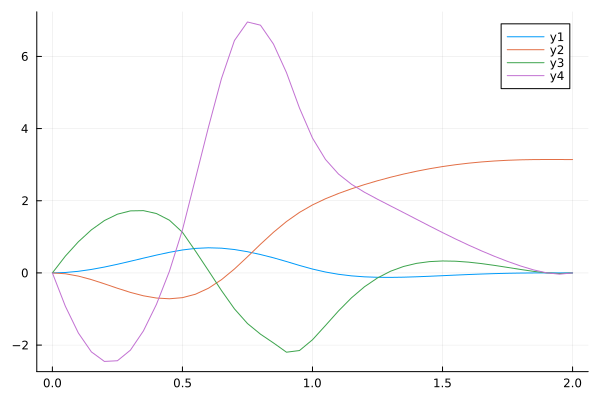

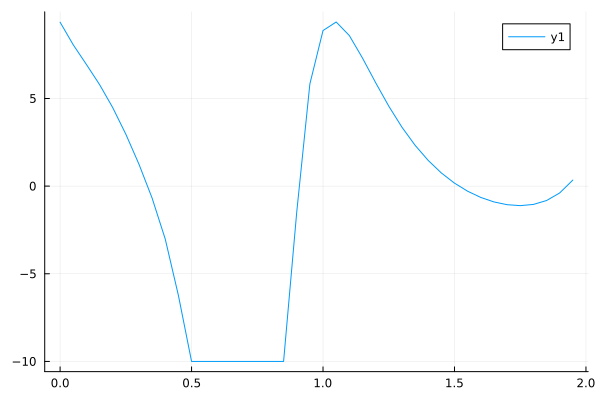

In [78]:
let 

    # problem size 
    nx = 4 
    nu = 1 
    dt = 0.05
    tf = 2.0 
    t_vec = 0:dt:tf 
    N = length(t_vec)
    
    # LQR cost 
    Q = diagm(ones(nx))
    R = 0.1*diagm(ones(nu))
    Qf = 10*diagm(ones(nx))
    
    # indexing 
    idx = create_idx(nx,nu,N)
    
    # initial and goal states 
    x0 = [0, 0, 0, 0]
    xf = [0, pi, 0, 0]
    Xref = [1*xf for _ = 1:N]
    Uref = [zeros(1) for _ = 1:N-1]
    
    # load all useful things into params 
    params = (
        Q = Q,
        R = R,
        Qf = Qf, 
        x0 = x0, 
        xf = xf, 
        Xref = Xref, 
        Uref = Uref,
        dt = dt,
        N = N, 
        idx = idx,
        mc = 1.0, 
        mp = 0.2, 
        l = 0.5
    )
    
    # primal bounds 
    x_min = -150 * ones(nx)
    x_max = +150 * ones(nx)
    u_min = -10 * ones(nu)
    u_max = +10 * ones(nu)

    Z_l = -Inf * ones(idx.nz)
    Z_u =  Inf * ones(idx.nz)

    # initial condition constraint 
    Z_l[idx.x[1]] = x0 
    Z_u[idx.x[1]] = x0 

    for i = 1:N-1 
        Z_l[idx.u[i]] = u_min 
        Z_u[idx.u[i]] = u_max 
    end
    for i = 2:N-1 
        Z_l[idx.x[i]] = x_min 
        Z_u[idx.x[i]] = x_max 
    end

    # terminal condition constraint 
    Z_l[idx.x[N]] = xf 
    Z_u[idx.x[N]] = xf 


    # constraint bounds 
    n_cons = (N - 1) * nx
    c_l = zeros(n_cons)
    c_u = zeros(n_cons)

    # initial guess 
    Z0 = .01*randn(idx.nz)

    # an intelligent way to initialize is 
    # for i = 1:N-1
    #     Z0[idx.x[i]] = # something 
    #     Z0[idx.u[i]] = # something 
    # end
    # Z[idx.x[N]] = # something 

    # evaluate the constraint jacobian once to get the sparsity structure 
    temp_con_jac = spzeros(n_cons, idx.nz)
    constraint_jacobian!(params, temp_con_jac, Z0)
    
    println("sparsity pattern of conjac: ")
    display(temp_con_jac)

    # call ipopt
    Z = lazy_nlp_qd.sparse_fmincon(cost::Function,
                                   cost_gradient!::Function,
                                   constraint!::Function,
                                   constraint_jacobian!::Function,
                                   temp_con_jac,
                                   Z_l::Vector,
                                   Z_u::Vector,
                                   c_l::Vector,
                                   c_u::Vector,
                                   Z0::Vector,
                                   params::NamedTuple;
                                   tol = 1e-4,
                                   c_tol = 1e-4,
                                   max_iters = 1_000,
                                   verbose = true)


    X = [Z[idx_x] for idx_x in idx.x]
    U = [Z[idx_u] for idx_u in idx.u]

    # this is how you would plot it 
    display(plot(t_vec, hcat(X...)'))
    display(plot(t_vec[1:end-1], hcat(U...)'))
    
end
